# Interactive learning "Active learning" 


This is a playground for an active learning setting for the course [interactive learning](https://www.mah.se/upload/FAKULTETER/TS/Forskning/Kursplan%20Interaktiv%20maskininl%C3%A4rning.pdf)

Seminar 2 on active learning with example sorting batteries in 2 classes "alkaline" and "chargeable"

This page uses the trained model from [this page](batteries.ipynb) and discusses how a algorithm can be constructed to select batteries to label. 

In [1]:
# Some get started stuff run this first reads the saved model etc.
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
import sys
import platform
#sys.path.append("../../") # go to parent dir
from fastaiold.imports import *
print(platform.python_version())
from fastaiold.transforms import *
from fastaiold.conv_learner import *
from fastaiold.model import *
from fastaiold.dataset import *
from fastaiold.sgdr import *
from fastaiold.plots import *
# set some variables
#PATH = "/storage/myData/batteries/"
PATH = "data/batteries_v4/"
arch=resnet34  ##Using the resnet34 model
sz=224
print(f'NVidia GPUs is called CUDA aviable {torch.cuda.is_available()}')
print(f'deep learning accelerator aviable CuDNN {torch.backends.cudnn.enabled}')
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.load("batteries_v4")
actimage = 0
test_path = PATH+'test/'
test_batch = np.array(os.listdir(test_path))

def predict_batteries(show_image=False):
    global actimage
    if actimage<test_batch.size:
        trn_tfms, val_tfms = tfms_from_model(arch,sz)
        img = open_image(test_path+test_batch[actimage])
        im = val_tfms(img)
        log_preds = learn.predict_array(im[None])
        probs = np.exp(log_preds)
        img = []
        titles = []
        imgName = test_batch[actimage]
        title=data.classes[np.argmax(probs)]+":"+str(np.around(probs[:,np.argmax(probs)],decimals=2))+":"+test_batch[actimage]
        titles.append(data.classes[np.argmax(probs)]+":"+str(np.around(probs[:,np.argmax(probs)],decimals=2))+":"+test_batch[actimage])    
        if show_image:
            img.append(plt.imread(test_path+test_batch[actimage]))
            actimage = actimage+1
            return plots(img,titles=titles,rows=1,figsize=(20,16))
        else:
            actimage = actimage+1
            return data.classes[np.argmax(probs)],np.around(probs[:,np.argmax(probs)],decimals=2),imgName
    else:
        actimage=0
        return 0,0,0
    
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        try:
            sp = f.add_subplot(rows, len(ims)//rows, i+1)
        except ValueError:
            print("")
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def show_images(img_name_array,rows=4):
    img = []
    titles = []
    for i in range (0,len(img_name_array)):
        #path = PATH +data.val_ds.fnames[img_name_array[i]]
        img.append(plt.imread(img_name_array[i]))
        titles.append(img_name_array[i])
        #print (data.val_ds.fnames[wrong_validation[i]]+":"+data.classes[y[wrong_validation[i]]])
        #print("Classified as: "+data.classes[preds[wrong_validation[i]]]+" should be "+data.classes[y[wrong_validation[i]]])
    plots(img,titles=titles,rows=rows,figsize=(20,14))
    

3.6.5
NVidia GPUs is called CUDA aviable True
deep learning accelerator aviable CuDNN True


## Predictions on test set
Gets the first battery, predicts and outputs result.

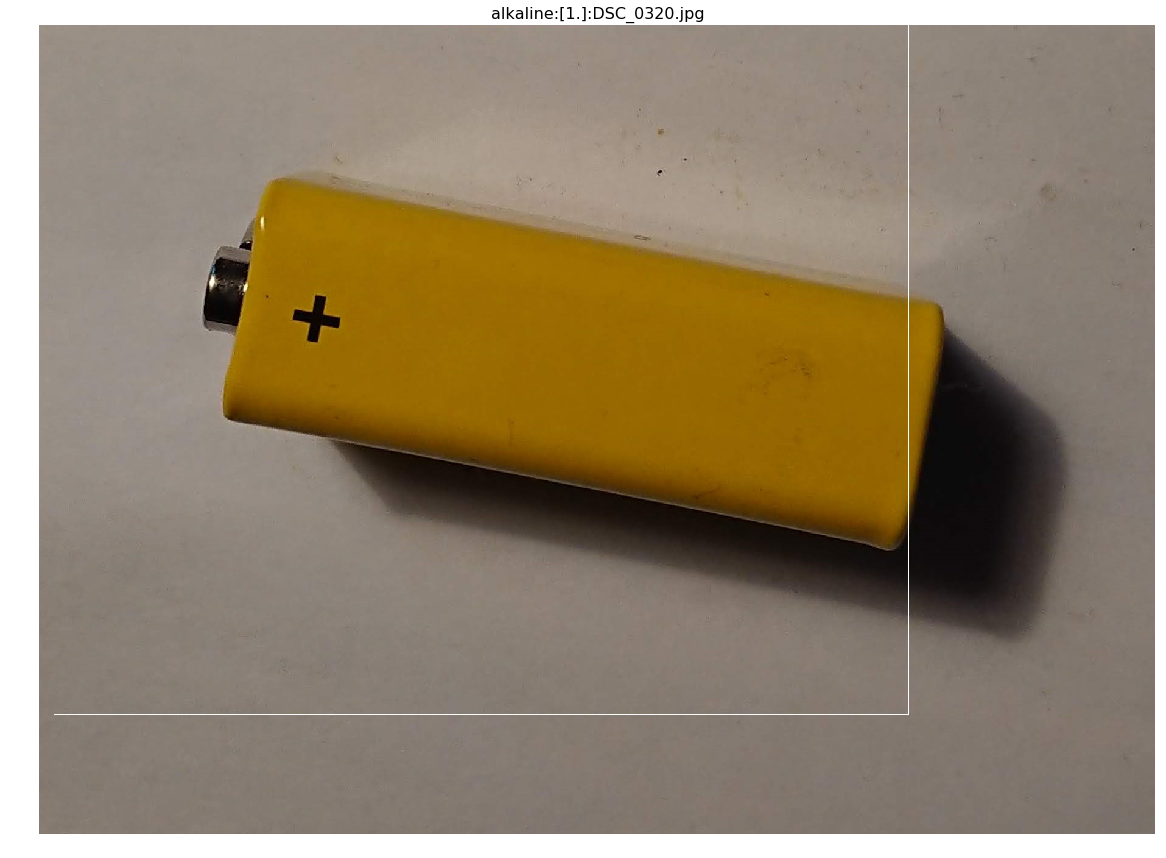

In [2]:
#Run multiple times to get next battery.
predict_batteries(show_image=True)

## Selecting which batteries to label
This is really the art in active learning, we cannot label all incoming samples since labelling comes with a cost. So we have to create an algorithm to select the samples that we think makes the model better. On the same time we can identify context drift and only label if we can identify that before we start labelling

In [3]:
#Stragegies
def random_strategy_label_this(percentage_selected=10):
    if random.randrange(0,100)<percentage_selected:
        return True
    else:
        return False

#Stragegies
def fixed_uncertainty_strategy_label_this(uncertainty,uncertainty_level=90):
    if uncertainty*100<uncertainty_level:
        return True
    else:
        return False

### Exploring the whole classification space
Batteries are selected randomly over the complete classification space. This works well when we expect context drift far from the classification boundaries. In our example, this represent for example a whole new battery brand.

In [5]:
budget = 10
labelling_cost = 2
accumulated_cost = 0
predictedclass,accuracy,name = predict_batteries(show_image=False) 
label_explore = []
while predictedclass is not 0:
    print("Predicted class:" + predictedclass +" with accuracy "+ str(accuracy[0]))
    if accumulated_cost < budget and random_strategy_label_this(percentage_selected=10):
        print("Label: "+name)
        label_explore.append(PATH+"test/"+name)
        accumulated_cost = accumulated_cost + labelling_cost
    predictedclass, accuracy, name = predict_batteries(show_image=False)

#Metric
print("Metric: "+str(budget-accumulated_cost))

Predicted class:alkaline with accuracy 0.99
Predicted class:chargeable with accuracy 0.62
Predicted class:chargeable with accuracy 0.99
Predicted class:chargeable with accuracy 0.96
Predicted class:alkaline with accuracy 0.64
Label: DSC_0407.jpg
Predicted class:chargeable with accuracy 0.99
Predicted class:chargeable with accuracy 0.78
Predicted class:alkaline with accuracy 0.98
Predicted class:chargeable with accuracy 1.0
Predicted class:alkaline with accuracy 0.51
Predicted class:chargeable with accuracy 0.91
Predicted class:chargeable with accuracy 0.78
Predicted class:alkaline with accuracy 0.97
Predicted class:alkaline with accuracy 0.97
Predicted class:chargeable with accuracy 0.87
Predicted class:alkaline with accuracy 0.98
Label: DSC_0342.jpg
Metric: 6


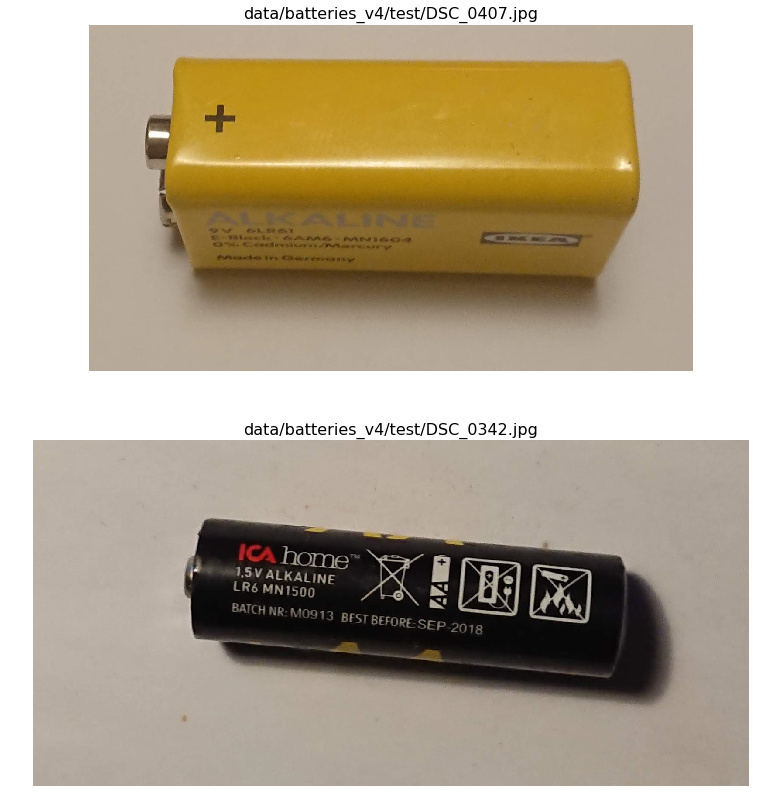

In [26]:
show_images(label_explore,rows=2)

### Exploiting the classification space
By exploiting the classification space, we dig into the nuances of batteries that are similar to each other. By selecting those batteries for labelling we are unsure of, we get better at distinguishing them. In our case, some yellow batteries are quite similar.

In [6]:
budget = 10
labelling_cost = 2
accumulated_cost = 0
predictedclass,accuracy,name = predict_batteries(show_image=False)
label_exploit = []
while predictedclass is not 0:
    print("Predicted class:" + predictedclass +" with accuracy "+ str(accuracy[0]))
    if accumulated_cost < budget and fixed_uncertainty_strategy_label_this(accuracy):
        print("Label: "+PATH+"test/"+name)
        label_exploit.append(PATH+"test/"+name)
        accumulated_cost = accumulated_cost + labelling_cost
    predictedclass, accuracy, name = predict_batteries(show_image=False)

#Metric
print("Metric: "+str(budget-accumulated_cost))

Predicted class:alkaline with accuracy 0.99
Predicted class:chargeable with accuracy 0.62
Label: data/batteries_v4/test/DSC_0281.jpg
Predicted class:chargeable with accuracy 0.99
Predicted class:chargeable with accuracy 0.96
Predicted class:alkaline with accuracy 0.64
Label: data/batteries_v4/test/DSC_0407.jpg
Predicted class:chargeable with accuracy 0.99
Predicted class:chargeable with accuracy 0.78
Label: data/batteries_v4/test/DSC_0410.jpg
Predicted class:alkaline with accuracy 0.98
Predicted class:chargeable with accuracy 1.0
Predicted class:alkaline with accuracy 0.51
Label: data/batteries_v4/test/DSC_0362.jpg
Predicted class:chargeable with accuracy 0.91
Predicted class:chargeable with accuracy 0.78
Label: data/batteries_v4/test/DSC_0363.jpg
Predicted class:alkaline with accuracy 0.97
Predicted class:alkaline with accuracy 0.97
Predicted class:chargeable with accuracy 0.87
Predicted class:alkaline with accuracy 0.98
Metric: 0


![](data/batteries/test/DSC_0355.jpg "DSC_0355.jpg")
![](data/batteries/test/DSC_0281.jpg "DSC_0281.jpg")
![](data/batteries/test/DSC_0357.jpg "DSC_0357.jpg")
![](data/batteries/test/DSC_0354.jpg "DSC_0354.jpg")
![](data/batteries/test/DSC_0342.jpg "DSC_0342.jpg")

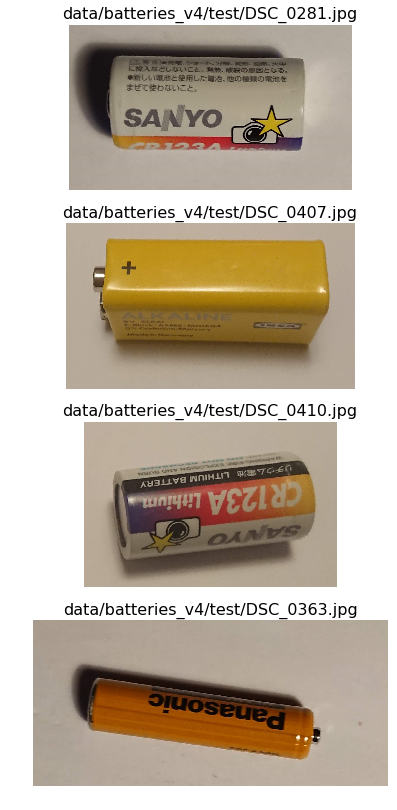

In [25]:
show_images(label_exploit)